# Step-by-step Tutorial on Multi-Domain Sequence Analysis

**Multi-domain sequence analysis** is a powerful approach to studying life course trajectories across multiple interrelated domains — such as family, work, and education. 

Instead of analyzing each domain (e.g., marriage or childbearing) separately, this method allows us to capture how life events unfold *together* across different areas of life.

### Why is this important?  

Because real lives are complex. For example, getting married might affect when someone leaves home or starts having children. Ignoring these interconnections can lead to oversimplified or even misleading conclusions.

### What Will You Learn?

In this tutorial, you will learn how to:

- **Prepare and align life course sequence data** across different domains  
- **Assess the association** between domains to see if and how they are related  
- Understand and apply the **four main strategies** for multi-domain sequence analysis:
  1. **IDCD** – Individual Domain Combined Dynamics  
  2. **CAT** – Concatenation of Aligned Trajectories  
  3. **DAT** – Distance Aggregation Technique  
  4. **CombT** – Combined Typology Strategy  

Each strategy has its own logic and use case. We'll use the `biofam` dataset from the `MedSeq` R package to illustrate the key differences between them.

Whether you're exploring family formation, education-employment transitions, or any multi-domain longitudinal data, this tutorial will provide you with a comprehensive hands-on introduction.

Let’s get started! 

In [1]:
from sequenzo import *

# Load datasets, and which dataset corresponds to one domain
left_df = load_dataset('biofam_left_domain')
children_df = load_dataset('biofam_child_domain')
married_df = load_dataset('biofam_married_domain')

# For example, let's take a look at the dataset about whether individuals left home or not
left_df

,id,age_15,age_16,age_17,age_18,age_19,age_20,age_21,age_22,age_23,age_24,age_25,age_26,age_27,age_28,age_29,age_30
0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1
1,2,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
2,3,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1
3,4,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1
4,5,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1996,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
1996,1997,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
1997,1998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1998,1999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Assessing whether and to what extent domains are associated with each other

To explore how different life domains (e.g. marriage, leaving home, having children) are related across time, we use **sequence association analysis**. This helps us understand **if** and **how strongly** two domains tend to move together across a person's life.

### Step 1: Create Sequence Objects

We first create sequence data objects for each domain (e.g. a sequence showing whether someone was married at each age). These objects are then compared **pairwise** to analyze their associations.


In [2]:
# Extract the columns related to age/time
# which is a prerequisite for building a sequence data.
time_cols = [col for col in children_df.columns if col.startswith("age_")]

# Construct a sequence data for each 
print("\n------ seq_lef t ------")
seq_left = SequenceData(data=left_df, 
                        time=time_cols,
                        states=[0, 1],
                        labels=["At home", "Left home"],
                        id_col='id')

print("\n------ seq_child ------")
seq_child = SequenceData(data=children_df, 
                         time=time_cols,
                         states=[0, 1],
                         labels=["No child", "Child"],
                         id_col='id')

print("\n------ seq_married ------")
seq_married = SequenceData(data=married_df, 
                        time=time_cols,
                        states=[0, 1],
                        labels=["Not married", "Married"],
                        id_col='id')


------ seq_lef t ------

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 2000
[>] Number of time points: 16
[>] Min/Max sequence length: 16 / 16
[>] States: [0, 1]
[>] Labels: ['At home', 'Left home']
[>] Weights: Not provided

------ seq_child ------

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 2000
[>] Number of time points: 16
[>] Min/Max sequence length: 16 / 16
[>] States: [0, 1]
[>] Labels: ['No child', 'Child']
[>] Weights: Not provided

------ seq_married ------

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 2000
[>] Number of time points: 16
[>] Min/Max sequence length: 16 / 16
[>] States: [0, 1]
[>] Labels: ['Not married', 'Married']
[>] Weights: Not provided


### Step 2: Measuring Association

We use two complementary statistical measures:

| Measure      | Description                                                                 | What it tells us                                       |
|--------------|-----------------------------------------------------------------------------|---------------------------------------------------------|
| **LRT (Likelihood Ratio Test)** | A test of **whether** two domains are statistically associated | Tells you **if there is any significant link** at all    |
| **Cramer's V (v)**              | A measure of **how strong** the association is (0 to 1)         | Tells you **how strong** the link is if it exists       |

Both of these are calculated **based on cross-tabulations** of aligned sequence positions (e.g., marriage status vs. childbearing at each age).

### What's the Difference?

- **LRT (`p(LRT)`):**  
  Think of this as a **yes/no test** — *Is there any relationship?*
  - A low p-value (e.g., < 0.05) means "Yes, the association is statistically significant."
  - A high p-value means there's no evidence of association.

- **Cramer's V (`v` and `p(v)`):**  
  This tells you **how strong** the relationship is, even if it's weak.
  - Value ranges from 0 (no association) to 1 (perfect association).
  - We also attach a label:
    - `None` (v < 0.1)
    - `Weak` (0.1 ≤ v < 0.3)
    - `Moderate` (0.3 ≤ v < 0.5)
    - `Strong` (v ≥ 0.5)

> **Note:** Even when `v = 0`, non-linear associations *might* exist — this test only captures **linear dependencies**.

### Output Table

The result is a table that looks like the following. 

Each row shows how two domains relate to each other, how statistically significant that relationship is, and how strong it is.

In [3]:
result = get_association_between_domains(
    [seq_left, seq_child, seq_married],
    assoc=["V", "LRT"],
    rep_method="overall",
    cross_table=True,
    weighted=True,
    dnames=["left", "children", "married"], 
    # It is domain name that you specify by yourself, e.g., seq_left - > left
    explain=True,
)


📜 Full results table:


,df,LRT,p(LRT),v,p(v),strength
left vs children,1.0,9144.680641,0.000 ***,0.481817,0.000 ***,Moderate
left vs married,1.0,9561.568952,0.000 ***,0.531414,0.000 ***,Strong
children vs married,1.0,12430.120849,0.000 ***,0.626851,0.000 ***,Strong



📘 Column explanations:
  - df       : Degrees of freedom for the test (typically 1 for binary state sequences).
  - LRT      : Likelihood Ratio Test statistic (higher = stronger dependence).
  - p(LRT)   : p-value for LRT + significance stars: * (p<.05), ** (p<.01), *** (p<.001)
  - v        : Cramer's V statistic (0 to 1, measures association strength).
  - p(v)     : p-value for Cramer's V (based on chi-squared test) + significance stars: * (p<.05), ** (p<.01), *** (p<.001)
  - strength : Qualitative label for association strength based on Cramer's V:
               0.00–0.09 → None, 0.10–0.29 → Weak, 0.30–0.49 → Moderate, ≥0.50 → Strong


## The first strategy to conduct multi-domain sequence analysis: IDCD - Individual Domain Combined Dynamics 

### Core Idea

Instead of analyzing each domain separately, **IDCD looks at what's happening in all domains *at the same time*, at every point in the life course**.

Think of it this way:  
* At each age, a person is in **one specific state** in each domain (e.g., *not married*, *has no children*, *still lives at home*).  
* IDCD creates a **combined state** from these — so now you're tracking sequences like:

> `At home + No child + Single` → `Left home + No child + Single` → `Left home + Child + Married` → ...

This results in **a new combined sequence** for each individual, reflecting how their entire life unfolds across all domains *together*.

### Why is this useful?

- It gives a **rich and detailed picture** of how domains evolve in parallel.
- We can directly compare full life-course trajectories that combine domains.
- It enables **standard sequence analysis** (like clustering, visualization, etc.) to be applied to these combined sequences.

### A Simple Example

Let’s say we have three life domains:

1. **Leaving home** — [0 = At home, 1 = Left home]  
2. **Having children** — [0 = No child, 1 = Has child]  
3. **Marital status** — [0 = Single, 1 = Married]

At age 18, a person might be:
- At home (0)
- No child (0)
- Single (0)

→ So we represent this as: `0+0+0`

At age 24, they might be:
- Left home (1)
- Has child (1)
- Married (1)

→ That becomes: `1+1+1`

The full sequence might look like this:

> `0+0+0 → 0+0+0 → 1+0+0 → 1+0+1 → 1+1+1`

### What Can You Do With This?

Once we have these combined sequences, we can:

- Visualize the most common patterns of life-course combinations
- Cluster individuals based on similar life trajectories
- Study the diversity and timing of transitions across groups

In short, **IDCD lets us zoom out and look at full life paths in a multidimensional way**, while keeping all the timing information intact.

Ready to try it out? Let’s construct combined sequences using the IDCD approach.


In [4]:
from sequenzo import *

left_df = load_dataset('biofam_left_domain')
children_df = load_dataset('biofam_child_domain')
married_df = load_dataset('biofam_married_domain')

time_cols = [col for col in children_df.columns if col.startswith("age_")]

common_path = './datasets'
csv_list = [f'{common_path}/biofam_left_domain.csv',
        f'{common_path}/biofam_child_domain.csv',
        f'{common_path}/biofam_married_domain.csv']

time_cols = [f"age_{i}" for i in range(15, 31)]

idcd_seqdata = create_idcd_sequence_from_csvs(
    csv_paths=csv_list,
    time_cols=time_cols,
    time_type="age",
    id_col="id",
    domain_state_labels=[
        {0: "At Home", 1: "Left Home"}, 
        # Pair of state-label for domain 1. e.g., for state 0, the corresponding label is "At Home"
        {0: "No Child", 1: "Child"},
        {0: "Single", 1: "Married"}
    ]
)


[IDCD] Observed Combined States Frequency Table:
State                          Label  Frequency  Proportion (%)
0+0+0    At Home + No Child + Single      16378           51.18
1+0+0  Left Home + No Child + Single       5888           18.40
1+1+1    Left Home + Child + Married       4838           15.12
1+0+1 Left Home + No Child + Married       3244           10.14
0+0+1   At Home + No Child + Married       1466            4.58
1+1+0     Left Home + Child + Single        167            0.52
0+1+0       At Home + Child + Single         19            0.06

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 2000
[>] Number of time points: 16
[>] Min/Max sequence length: 16 / 16
[>] States: ['0+0+0', '1+0+0', '1+1+1', '1+0+1', '0+0+1', '1+1+0', '0+1+0']
[>] Labels: ['At Home + No Child + Single', 'Left Home + No Child + Single', 'Left Home + Child + Married', 'Left Home + No Child + Married', 'At Home + No Child + Married', 'Left Home + Child + Single',

After this, we can follow the common workflow of sequence analysis.

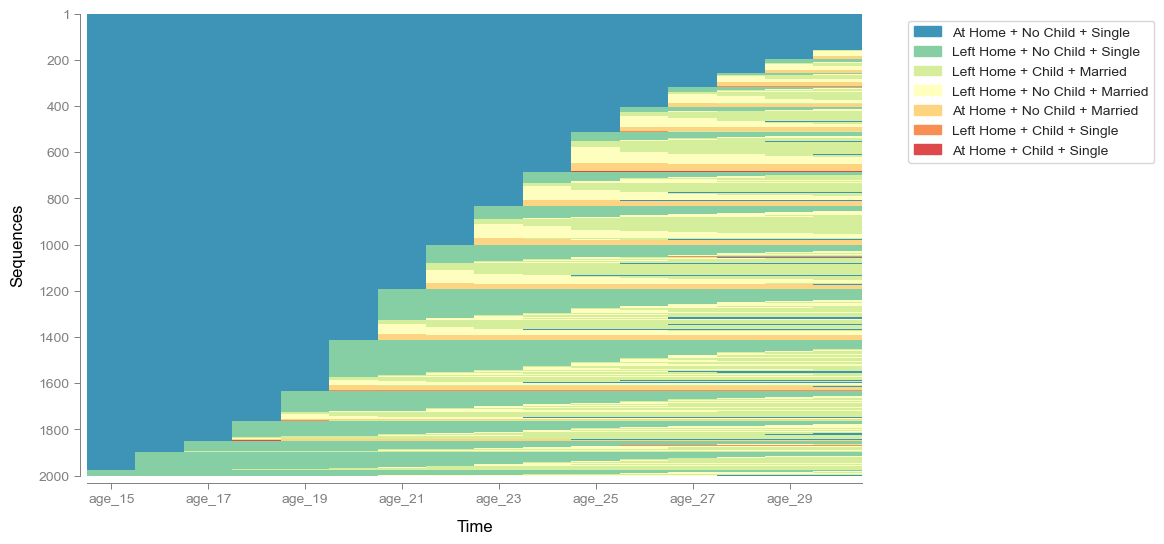

In [5]:
plot_sequence_index(idcd_seqdata, 
                    # save_as='index_plot_idcd'
                    )

In [6]:
# You can keep working on the rest, such as dissimilarity measures and cluster analysis.

# You can also replace "OMspell" with "OM/DHD/HAM" and "TRATE" with "CONSTANT"
om = get_distance_matrix(seqdata=idcd_seqdata,
                         method='OM',
                         sm="TRATE",
                         indel="auto")
om

[>] Processing 2000 sequences with 7 unique states.
[>] Transition-based substitution-cost matrix (TRATE) initiated...
  - Computing transition probabilities for: [0+0+0, 1+0+0, 1+1+1, 1+0+1, 0+0+1, 1+1+0, 0+1+0]
[>] generated an indel of type number

[>] Identified 537 unique sequences.
[>] Starting Optimal Matching(OM)...
[>] Computing all pairwise distances...
[>] Computed Successfully.


,1,2,3,4,5,6,7,8,9,10,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
1,0.000000,19.568552,9.892138,21.565025,15.632939,13.852890,13.922955,13.439323,3.938037,19.315179,...,13.852890,21.565025,13.841673,11.869920,13.870619,7.638765,17.232596,13.852890,25.775105,7.749470
2,19.568552,0.000000,11.730345,9.916578,7.892138,29.347639,29.513746,13.331461,21.261247,5.777920,...,29.347639,9.916578,25.568552,27.364668,29.365367,15.485626,7.695802,29.347639,29.837333,21.417712
3,9.892138,11.730345,0.000000,11.740801,5.808715,17.634323,17.848452,3.800558,11.562196,15.584834,...,17.634323,11.740801,13.838207,15.651353,17.652052,7.755282,9.946069,17.634323,25.857748,13.670338
4,21.565025,9.916578,11.740801,0.000000,5.932086,21.406759,21.784276,11.650525,21.563223,13.954724,...,21.406759,0.000000,17.514621,21.438051,21.568552,15.787602,15.643672,21.406759,25.950717,21.719687
5,15.632939,7.892138,5.808715,5.932086,0.000000,21.517464,21.750916,7.579782,15.631137,9.946069,...,21.517464,5.932086,17.676414,19.534493,21.535192,9.855516,9.833155,21.517464,25.917357,15.787602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,7.638765,15.485626,7.755282,15.787602,9.855516,19.719001,19.760367,9.356397,9.804148,11.676414,...,19.719001,15.787602,15.946069,17.736031,19.736730,0.000000,13.239881,19.719001,25.848236,5.932086
1997,17.232596,7.695802,9.946069,15.643672,9.833155,27.428562,27.556024,7.946069,19.342171,11.210389,...,27.428562,15.643672,23.784276,25.445592,27.446291,13.239881,0.000000,27.428562,27.860287,18.941231
1998,13.852890,29.347639,17.634323,21.406759,21.517464,0.000000,13.827509,19.561486,9.914853,31.395415,...,0.000000,21.406759,3.892138,1.982971,5.926075,19.719001,27.428562,0.000000,25.679659,19.829706
1999,25.775105,29.837333,25.857748,25.950717,25.917357,25.679659,11.852150,25.872858,25.747267,31.760367,...,25.679659,25.950717,25.728942,25.693181,19.753584,25.848236,27.860287,25.679659,0.000000,25.814876


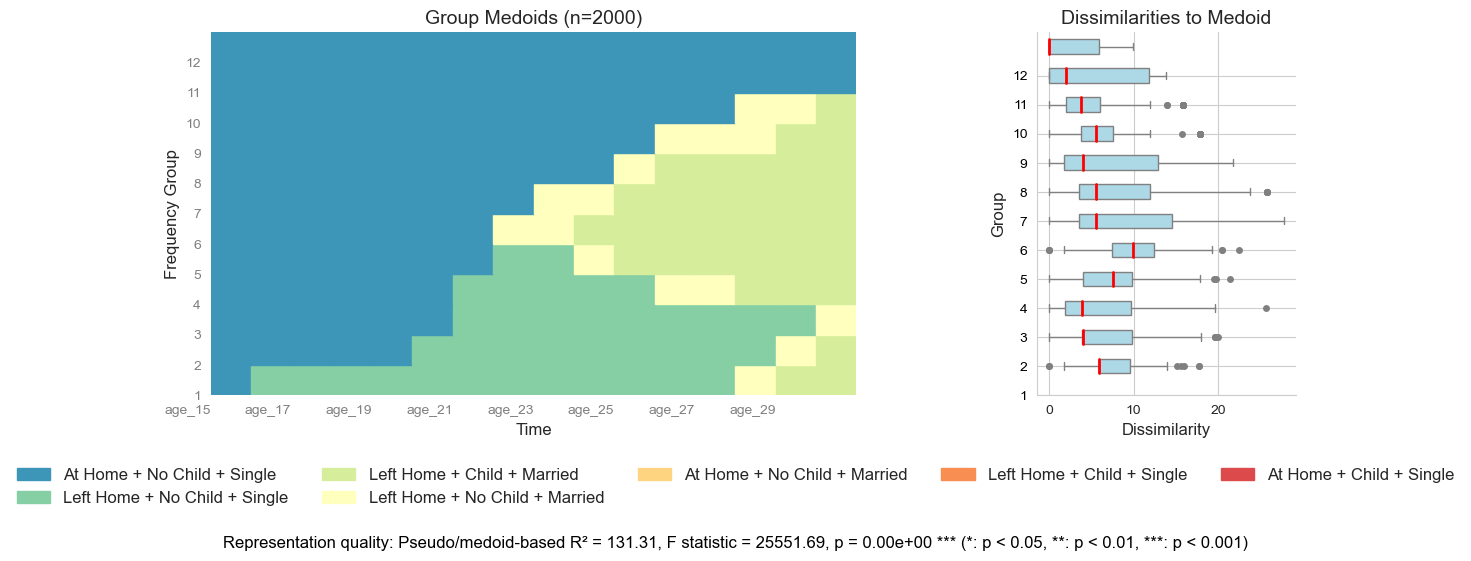

In [7]:
plot_relative_frequency(seqdata=idcd_seqdata, 
                        distance_matrix=om, 
                        num_groups=12, 
                        dpi=200, 
                        # save_as='relative_frequency_plot'
                        )



[>] Converting DataFrame to NumPy array...
[>] Note: 'ward' method maps to 'ward_d' (classic Ward method).
    Use 'ward_d2' for Ward method with squared Euclidean distances.
  - Checking R runtime environment and fastcluster.


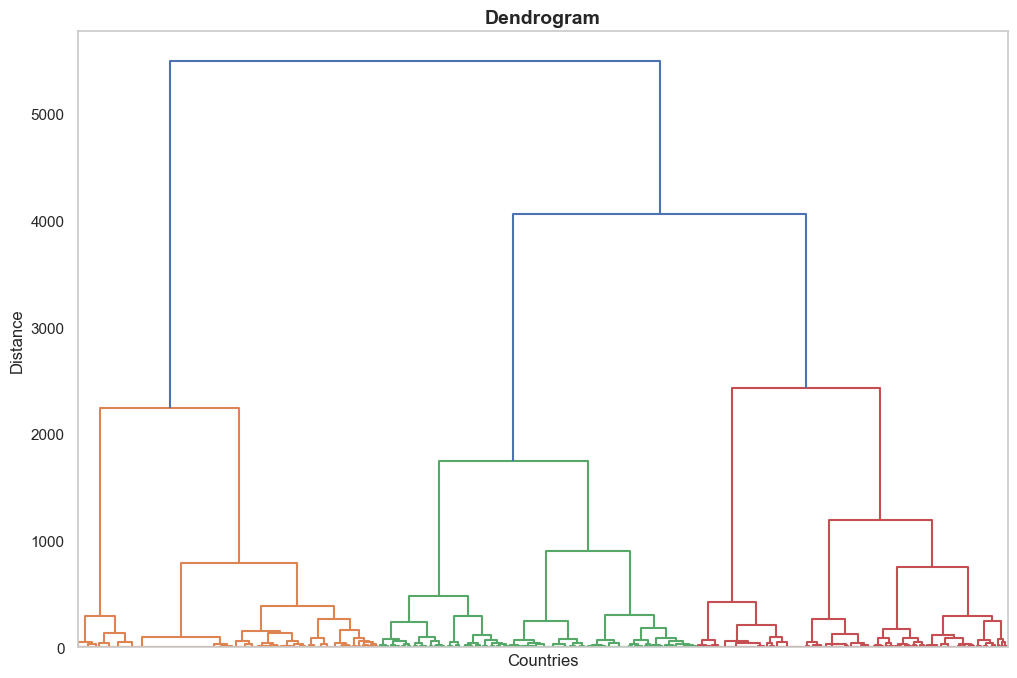

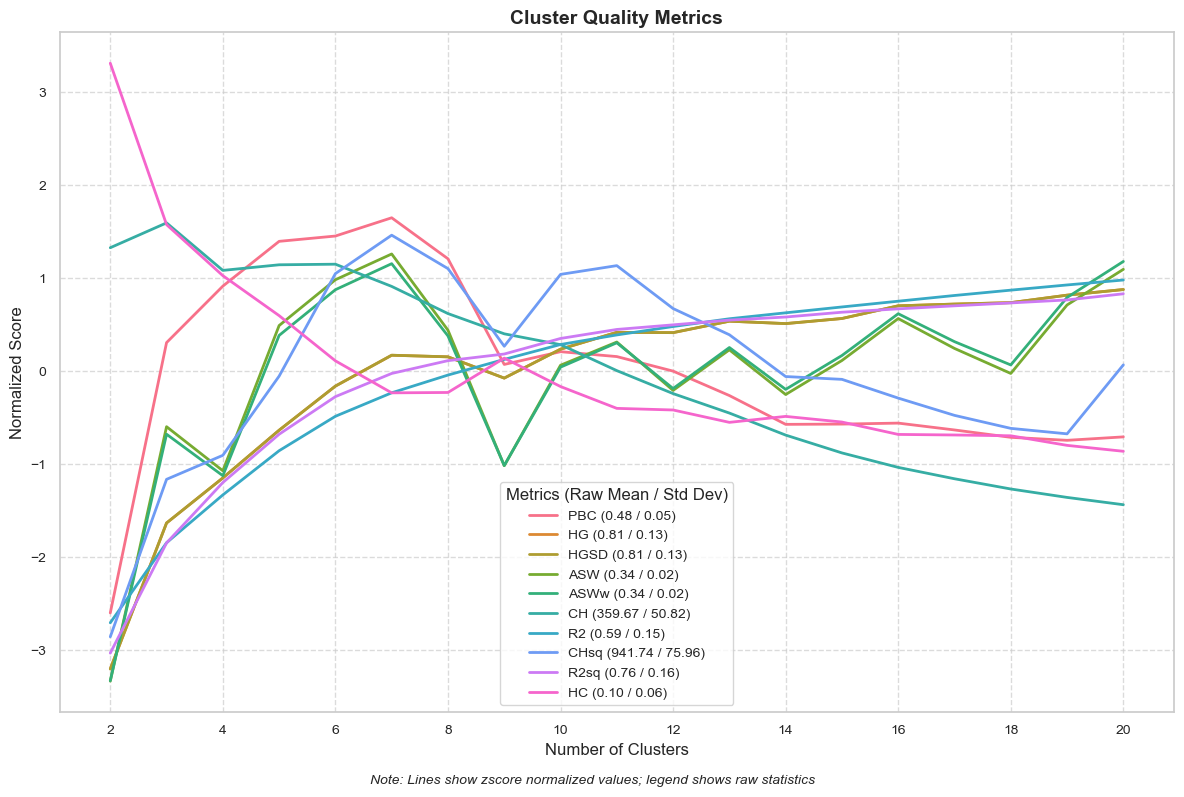

  Metric  Opt. Clusters    Raw Value  Z-Score Norm.
0    PBC              7     0.563882       1.649042
1     HG             20     0.921231       0.877400
2   HGSD             20     0.920860       0.877266
3    ASW              7     0.360163       1.259769
4   ASWw             20     0.362555       1.179199
5     CH              3   440.687301       1.594230
6     R2             20     0.733385       0.979736
7   CHsq              7  1052.764954       1.461773
8   R2sq             20     0.900849       0.831391
9     HC              2     0.288518       3.311207


In [8]:
cluster = Cluster(om, idcd_seqdata.ids, clustering_method='ward')
cluster.plot_dendrogram(xlabel="Countries", ylabel="Distance")

# Create a ClusterQuality object to evaluate clustering quality
cluster_quality = ClusterQuality(cluster)
cluster_quality.compute_cluster_quality_scores()
cluster_quality.plot_cqi_scores(norm='zscore', save_as='combined_scores')
summary_table = cluster_quality.get_cqi_table()
print(summary_table)

      Entity ID  Cluster
0             1        3
1             2        3
2             3        3
3             4        4
4             5        3
...         ...      ...
1995       1996        3
1996       1997        3
1997       1998        2
1998       1999        1
1999       2000        3

[2000 rows x 2 columns]
   Cluster  Count  Percentage
0        1    137        6.85
1        2    509       25.45
2        3    686       34.30
3        4    232       11.60
4        5    436       21.80


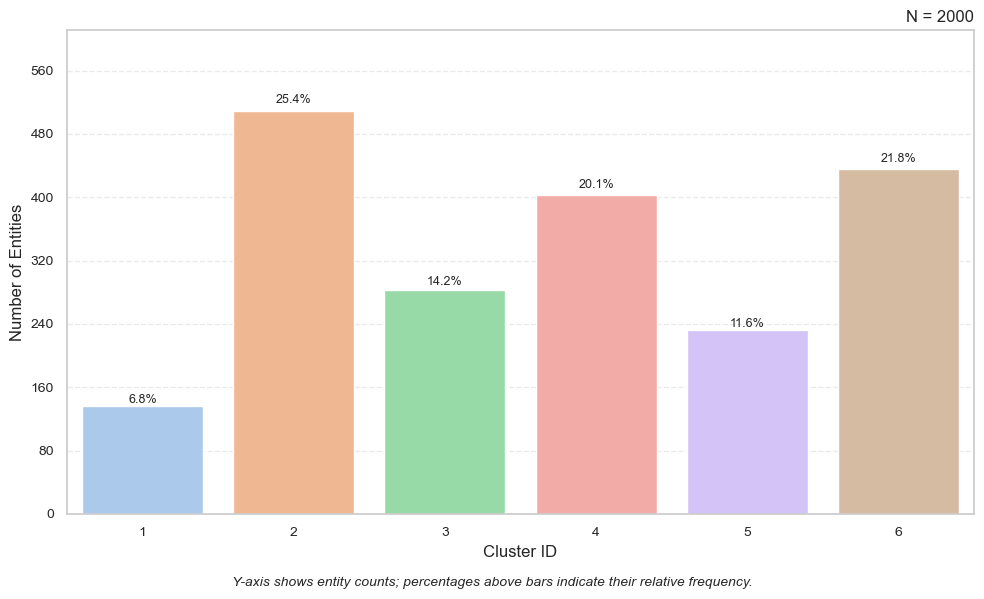

In [9]:
cluster_results = ClusterResults(cluster)
membership_table = cluster_results.get_cluster_memberships(num_clusters=5)
print(membership_table)
distribution = cluster_results.get_cluster_distribution(num_clusters=5)
print(distribution)
cluster_results.plot_cluster_distribution(num_clusters=6, save_as="distribution.png", title=None)


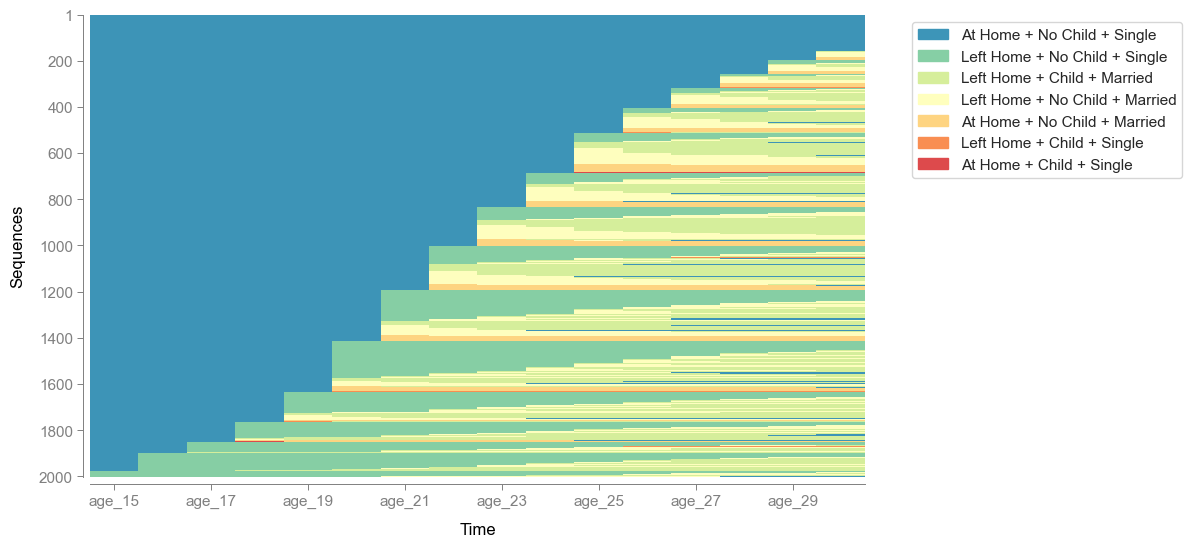

In [10]:
plot_sequence_index(seqdata=idcd_seqdata,

                    # save_as='cluster_index_plot',
                    )

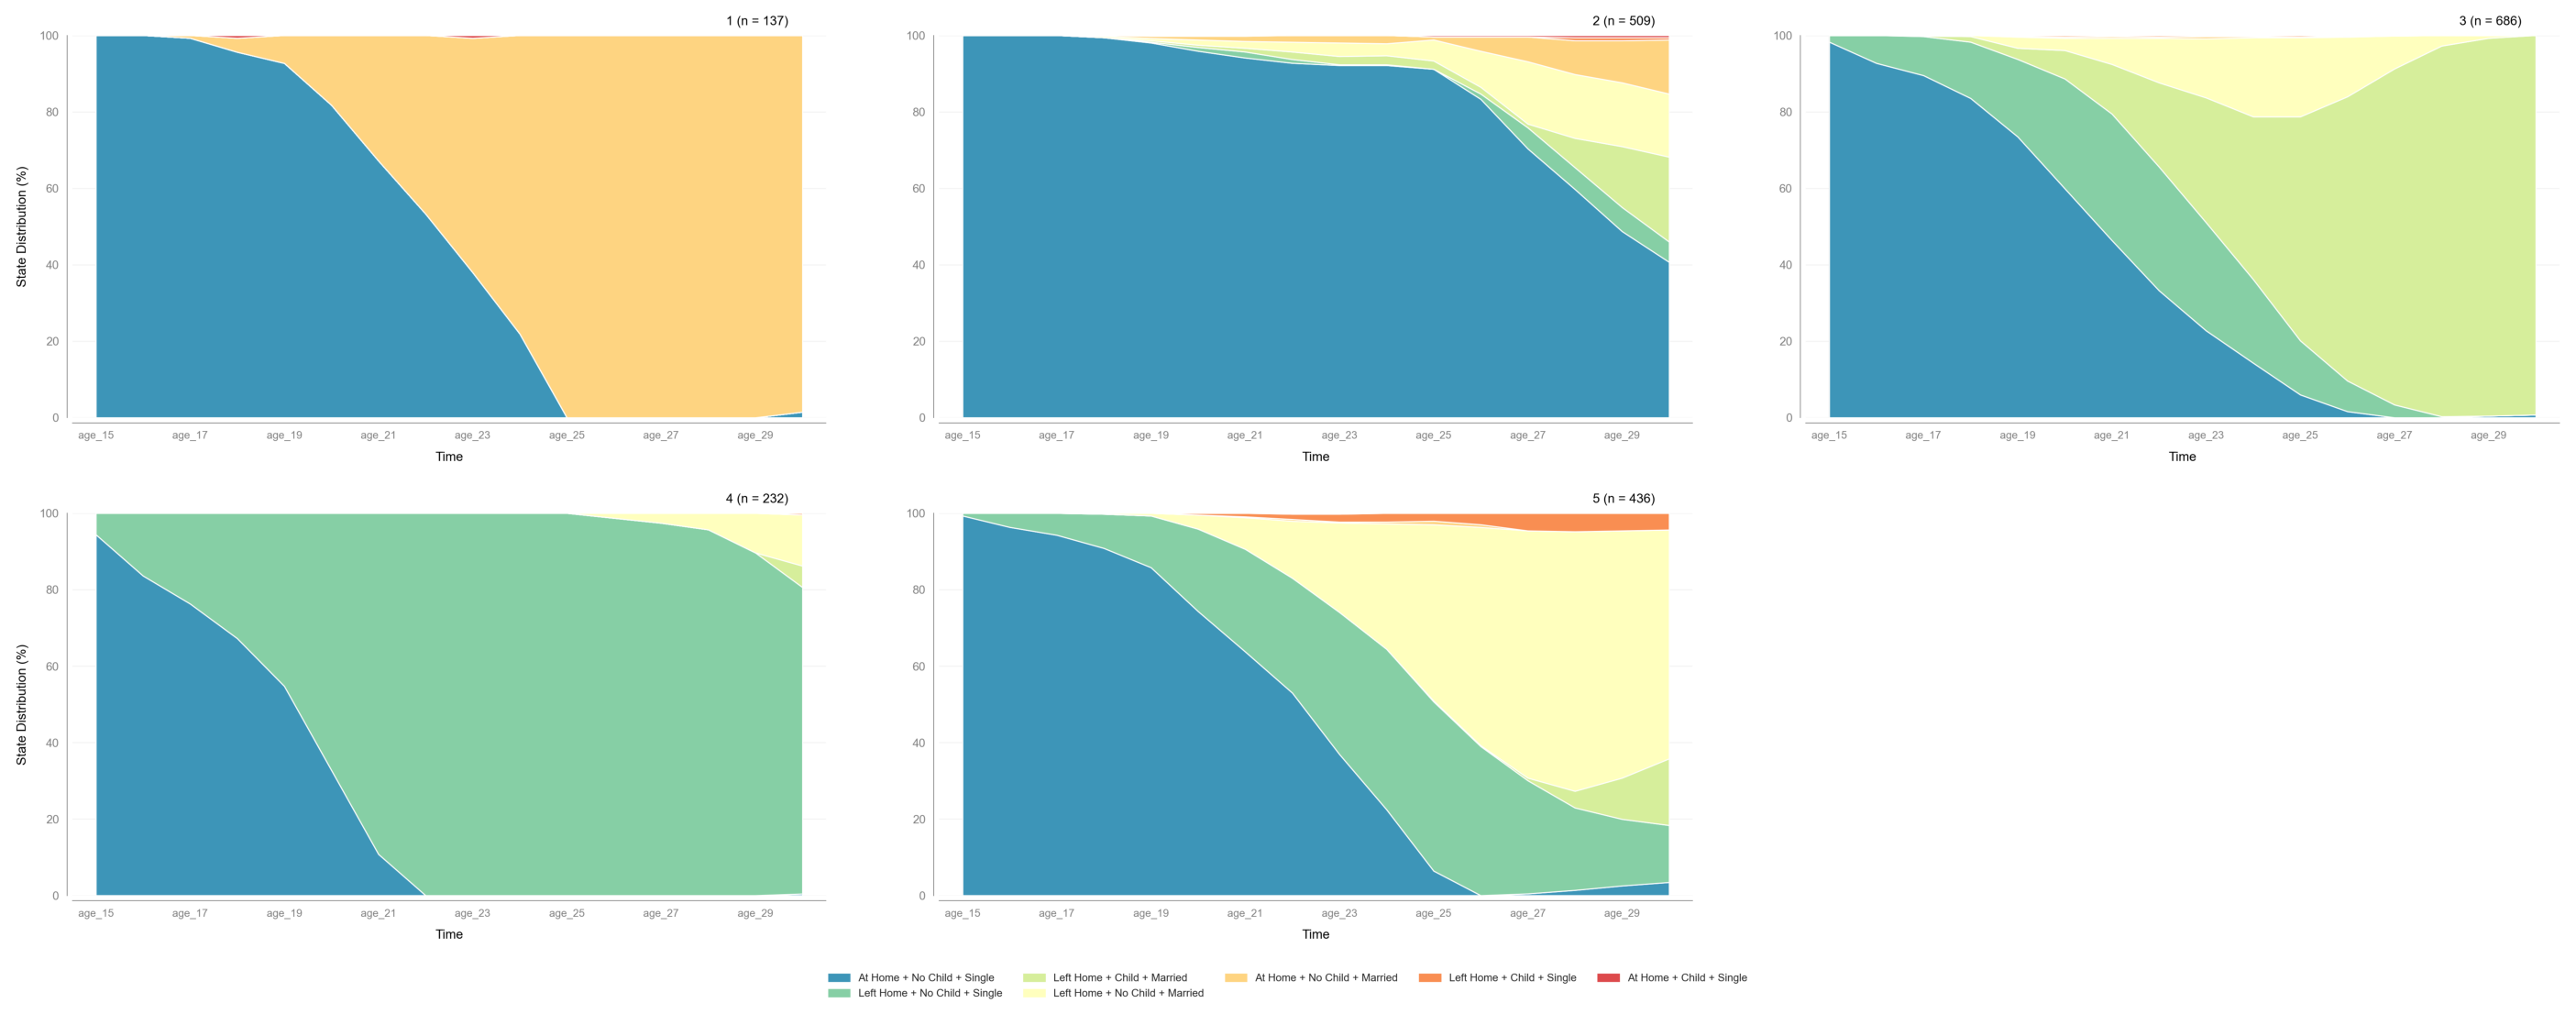

In [11]:
plot_state_distribution(seqdata=idcd_seqdata,
                    group_dataframe=membership_table,
                    group_column_name='Cluster',
                    # save_as='cluster_index_plot',
                    )

## The second strategy for multi-domain sequence analysis: CAT — Concatenation of Aligned Trajectories

### Core Idea

While **IDCD combines all domains at each point in time**, **CAT simply *sticks the domains together* — one after another** — to form one long “super sequence.”

Think of CAT as **gluing together** the individual sequences from each domain, rather than fusing them in time.

### How It Works

Let’s say you’re tracking a person’s life from age 15 to 30, across three domains:

1. **Leaving home** (16 years of data)  
2. **Having children** (16 years)  
3. **Marital status** (16 years)

Each domain is a sequence on its own — like:

- Leaving home: `0, 0, 0, 1, 1, 1, ..., 1`
- Having children: `0, 0, 0, 0, 1, 1, ..., 1`
- Marriage: `0, 0, 0, 0, 0, 1, ..., 1`

**CAT just puts them side-by-side** into a single sequence of length 48:

> `0, 0, 0, ..., 1` (Leaving home)  
> `0, 0, 0, ..., 1` (Children)  
> `0, 0, 0, ..., 1` (Marriage)

→ Final CAT sequence:  
`0, 0, 0, ..., 1, 0, 0, ..., 1, 0, 0, ..., 1`

So it’s still **a single sequence per individual**, but **the three domains are placed sequentially, not simultaneously**.

### How Is This Different from IDCD?

| Feature              | IDCD                               | CAT                                  |
|----------------------|-------------------------------------|---------------------------------------|
| How domains are used | Combined *at each point in time*    | Placed one *after another*            |
| Sequence length      | Same as one domain (e.g., 16)       | Sum of all domain lengths (e.g., 48)  |
| Goal                 | Capture *inter-domain synchronicity*| Capture *overall life trajectory*     |
| Example unit         | `"0+0+1"` (combined state)          | `0, 0, 0, ..., 1` (concatenated states)|

### Why Use CAT?

- You preserve the **order of events across all domains**, even when they happen at different times.
- You avoid creating *too many combined states* (a problem in IDCD when domains have many states).
- You can **use standard sequence clustering tools**, treating each CAT sequence as a “full life history.”

### Example Scenario

Imagine three people:

| Person | Leaving Home       | Children           | Marriage          |
|--------|--------------------|--------------------|-------------------|
| A      | `0, 0, 1, 1, ...`  | `0, 0, 0, 1, ...`  | `0, 0, 0, 0, ...` |
| B      | `0, 1, 1, 1, ...`  | `0, 0, 0, 0, ...`  | `0, 1, 1, 1, ...` |

Their CAT sequences would look like this:

- **A**: `[0, 0, 1, 1, ..., 0, 0, 0, 1, ..., 0, 0, 0, 0, ...]`
- **B**: `[0, 1, 1, 1, ..., 0, 0, 0, 0, ..., 0, 1, 1, 1, ...]`

You can now **cluster** people based on these full-path patterns — and ask questions like:

> “Are there typical paths through life when we look across all domains, not just one?”



In [12]:
# NOTE: please make sure that all the domain dataframes follow the same column names. 

left_df = load_dataset('biofam_left_domain')
children_df = load_dataset('biofam_child_domain')
married_df = load_dataset('biofam_married_domain')

time_cols = [col for col in children_df.columns if col.startswith("age_")]

seq_left = SequenceData(data=left_df, time=time_cols, states=[0, 1],
                        labels=["At home", "Left home"], id_col='id')
seq_child = SequenceData(data=children_df, time=time_cols, states=[0, 1],
                         labels=["No child", "Child"], id_col='id')
seq_marr = SequenceData(data=married_df, time=time_cols, states=[0, 1],
                        labels=["Not married", "Married"], id_col='id')

sequence_data = [seq_left, seq_child, seq_marr]

cat_distance_matrix = compute_cat_distance_matrix(sequence_data, 
                                                  method="OM", 
                                                  sm=["CONSTANT"],
                                                  indel=[1, 1, 1],  # indel=[1, 1] if you have two domains
                                                  what="diss", 
                                                  link="sum")

cat_distance_matrix


[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 2000
[>] Number of time points: 16
[>] Min/Max sequence length: 16 / 16
[>] States: [0, 1]
[>] Labels: ['At home', 'Left home']
[>] Weights: Not provided

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 2000
[>] Number of time points: 16
[>] Min/Max sequence length: 16 / 16
[>] States: [0, 1]
[>] Labels: ['No child', 'Child']
[>] Weights: Not provided

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 2000
[>] Number of time points: 16
[>] Min/Max sequence length: 16 / 16
[>] States: [0, 1]
[>] Labels: ['Not married', 'Married']
[>] Weights: Not provided
[>] 3 domains with 2000 sequences.
[>] Building MD sequences of combined states.
  - OK.
[>] Computing substitution cost matrix for domain 0.
[>] Computing substitution cost matrix for domain 1.
[>] Computing substitution cost matrix for domain 2.
[>] Computing MD substitution 

,1,2,3,4,5,6,7,8,9,10,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
1,0.0,26.0,20.0,48.0,48.0,18.0,14.0,16.0,8.0,24.0,...,18.0,48.0,20.0,16.0,18.0,12.0,18.0,18.0,26.0,12.0
2,26.0,0.0,16.0,28.0,16.0,34.0,38.0,22.0,20.0,16.0,...,34.0,28.0,36.0,32.0,34.0,22.0,14.0,34.0,62.0,40.0
3,20.0,16.0,0.0,26.0,8.0,22.0,30.0,6.0,14.0,32.0,...,22.0,26.0,24.0,20.0,22.0,20.0,26.0,22.0,48.0,28.0
4,48.0,28.0,26.0,0.0,12.0,22.0,50.0,26.0,42.0,38.0,...,22.0,0.0,18.0,26.0,34.0,44.0,38.0,22.0,74.0,62.0
5,48.0,16.0,8.0,12.0,0.0,22.0,38.0,16.0,48.0,26.0,...,22.0,12.0,26.0,20.0,22.0,48.0,26.0,22.0,56.0,48.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,12.0,22.0,20.0,44.0,48.0,20.0,20.0,26.0,10.0,12.0,...,20.0,44.0,24.0,18.0,20.0,0.0,12.0,20.0,30.0,12.0
1997,18.0,14.0,26.0,38.0,26.0,44.0,32.0,20.0,30.0,26.0,...,44.0,38.0,44.0,42.0,44.0,12.0,0.0,44.0,48.0,20.0
1998,18.0,34.0,22.0,22.0,22.0,0.0,28.0,32.0,10.0,32.0,...,0.0,22.0,4.0,2.0,12.0,20.0,44.0,0.0,52.0,20.0
1999,26.0,62.0,48.0,74.0,56.0,52.0,24.0,48.0,32.0,56.0,...,52.0,74.0,56.0,48.0,40.0,30.0,48.0,52.0,0.0,12.0


After this, we can follow the common workflow of sequence analysis.

In [13]:
# For instance, you can do cluster analysis and visualization based on the clusters. 


## The third strategy for multi-domain sequence analysis: DAT — Distance Aggregation of Trajectories

**DAT** takes a very different approach compared to IDCD and CAT. Instead of modifying or combining the sequences directly, **DAT combines the distances between sequences** across multiple domains.

### Core Idea

You don’t always need to *combine the sequences* — sometimes, it’s better to **combine how different people are similar or different** in each domain.

DAT works like this:

1. In each domain (e.g., marriage, children, leaving home), compute **a distance matrix** — how different is person A from B in that domain?
2. Then, **aggregate these distances** across domains into a single distance matrix.
3. Use this combined distance matrix for **clustering or visualization**, as if it came from one “meta-domain.”

> DAT is like comparing *life patterns* instead of *life states*.

### Intuition: Distance-first, not sequence-first

Imagine two people:

| Person | Marriage            | Children           | Leaving Home       |
|--------|---------------------|--------------------|--------------------|
| A      | `0, 0, 0, 1, 1...`  | `0, 0, 1, 1, 1...` | `0, 1, 1, 1, 1...` |
| B      | `0, 0, 0, 0, 1...`  | `0, 0, 0, 1, 1...` | `0, 0, 1, 1, 1...` |

- In each domain, we can calculate how similar A and B are.
- Then DAT aggregates these three distances (e.g., by adding or averaging them) to get **a global distance** between A and B.

We **never need to combine sequences** directly — just the distances.

### Technical Note

The aggregation can be done in various ways:
- **Sum of distances** across domains (default)
- **Weighted sum** (e.g., some domains are more important)
- Other tricks like **normalization**, if needed

The key requirement is that all distance matrices are comparable — e.g., based on the same method like Optimal Matching (OM), DHD, etc.

### How DAT Differs from Other Strategies

| Strategy | How it combines domains             | Key unit for analysis        |
|----------|-------------------------------------|------------------------------|
| IDCD     | Fuses *states* at each time point   | Combined state sequences     |
| CAT      | Concatenates domain sequences       | One long sequence per person |
| **DAT**  | Aggregates *distances* between people| Combined distance matrix     |

### Example Scenario

Let’s say we compute **pairwise distances** between 2,000 individuals in:

- Domain 1 (Leaving Home): `D₁`
- Domain 2 (Children): `D₂`
- Domain 3 (Marriage): `D₃`

Then, the **DAT distance** between Person A and B is:

> `DAT_Distance(A,B) = D₁(A,B) + D₂(A,B) + D₃(A,B)`

Once we have this full matrix, we can use it with:
- Hierarchical clustering
- MDS (Multidimensional Scaling)
- t-SNE or UMAP

→ All based on overall **similarity across life domains**.

### Why Use DAT?

- You **don’t lose detail** by merging states or sequences.
- You can mix **different distance methods** per domain if needed.
- It’s **statistically elegant** — it focuses on *structure* of similarity, not exact paths.

### Practical Tip

You can still examine:
- Which domain contributes most to the distance
- Whether certain clusters are closer in some domains than others

DAT offers **flexibility** and **modularity** — especially when domains are hard to align or interpret jointly.



In [14]:
left_df = load_dataset('biofam_left_domain')
children_df = load_dataset('biofam_child_domain')
married_df = load_dataset('biofam_married_domain')

time_cols = [col for col in children_df.columns if col.startswith("age_")]

seq_left = SequenceData(data=left_df, time=time_cols, states=[0, 1],
                        labels=["At home", "Left home"], id_col='id')
seq_child = SequenceData(data=children_df, time=time_cols, states=[0, 1],
                         labels=["No child", "Child"], id_col='id')
seq_marr = SequenceData(data=married_df, time=time_cols, states=[0, 1],
                        labels=["Not married", "Married"], id_col='id')

domains_seq_list = [seq_left, seq_child, seq_marr]

domain_params = [
    {"method": "OM", "sm": "TRATE", "indel": "auto"},
    {"method": "OM", "sm": "CONSTANT", "indel": "auto"},
    {"method": "DHD"}   
]

dat_matrix = compute_dat_distance_matrix(domains_seq_list, method_params=domain_params)

dat_matrix


[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 2000
[>] Number of time points: 16
[>] Min/Max sequence length: 16 / 16
[>] States: [0, 1]
[>] Labels: ['At home', 'Left home']
[>] Weights: Not provided

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 2000
[>] Number of time points: 16
[>] Min/Max sequence length: 16 / 16
[>] States: [0, 1]
[>] Labels: ['No child', 'Child']
[>] Weights: Not provided

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 2000
[>] Number of time points: 16
[>] Min/Max sequence length: 16 / 16
[>] States: [0, 1]
[>] Labels: ['Not married', 'Married']
[>] Weights: Not provided
[>] Processing 2000 sequences with 2 unique states.
[>] Transition-based substitution-cost matrix (TRATE) initiated...
  - Computing transition probabilities for: [0, 1]
[>] generated an indel of type number

[>] Identified 64 unique sequences.
[>] Starting Optimal Matching(OM)

,1,2,3,4,5,6,7,8,9,10,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000
1,0.000000,26.557654,20.813797,45.450287,28.308613,51.160212,25.323158,21.041113,13.137805,19.129775,...,51.160212,45.450287,47.353595,43.539009,40.018538,7.709925,21.081951,51.160212,48.525782,25.101763
2,26.557654,0.000000,17.095842,34.119099,16.977425,55.055490,43.880812,13.516541,21.033083,15.234496,...,55.055490,34.119099,51.248874,47.434287,43.913816,22.847730,12.993290,55.055490,67.083436,40.239568
3,20.813797,17.095842,0.000000,24.636490,7.494817,37.959649,34.136955,7.579300,15.289225,32.330338,...,37.959649,24.636490,34.153032,30.338446,26.817975,20.910488,26.282515,37.959649,57.339578,38.302327
4,45.450287,34.119099,24.636490,0.000000,17.141674,20.936391,46.773445,24.409174,39.925716,49.353595,...,20.936391,0.000000,17.129775,24.750977,32.078065,41.740362,43.305772,20.936391,69.976069,59.132200
5,28.308613,16.977425,7.494817,17.141674,0.000000,38.078065,41.631771,11.267500,22.784042,32.211921,...,38.078065,17.141674,34.271449,30.456862,26.936391,24.598688,26.164098,38.078065,64.834395,41.990527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,7.709925,22.847730,20.910488,41.740362,24.598688,58.870137,33.033083,17.331188,20.847730,11.419850,...,58.870137,41.740362,55.063520,51.248934,47.728463,0.000000,17.372027,58.870137,56.235707,17.391838
1997,21.081951,12.993290,26.282515,43.305772,26.164098,64.242163,38.405110,22.703215,30.219756,13.565410,...,64.242163,43.305772,60.435547,56.620961,53.100489,17.372027,0.000000,64.242163,54.090146,27.246278
1998,51.160212,55.055490,37.959649,20.936391,38.078065,0.000000,25.837054,41.538949,38.022407,70.289987,...,0.000000,20.936391,3.806617,7.621203,11.141674,58.870137,64.242163,0.000000,49.039678,76.261975
1999,48.525782,67.083436,57.339578,69.976069,64.834395,49.039678,23.202624,53.566895,50.050353,67.655556,...,49.039678,69.976069,52.846294,49.225091,37.898004,56.235707,54.090146,49.039678,0.000000,50.843868


After this, we can follow the common workflow of sequence analysis.

In [15]:
# For instance, you can do cluster analysis and visualization based on the clusters. 



## The fourth strategy for multi-domain sequence analysis: CombT — Combined Typology

**CombT** stands for **Combined Typology**, and it's a helpful strategy when you want to cluster individuals **based on their patterns in each domain separately**, then **combine** those domain-level clusters into one **global typology**.

### Core Idea

Rather than trying to forcefully merge different life domains (like in IDCD or CAT), **CombT lets each domain speak for itself first**.

Here's the process:

1. Cluster each domain **individually** using its own distance matrix.
2. Assign each individual a **cluster label** per domain.
3. Combine these labels (like "LeftCluster=1 + ChildCluster=2 + MarriedCluster=1") into a new string — this is the **Combined Typology (CombT)**.
4. Optionally, merge rare combinations if needed (e.g., clusters with too few people).

> So an individual's CombT label might look like: `"2+1+3"` → Cluster 2 in Domain A, Cluster 1 in Domain B, Cluster 3 in Domain C.

### What You Get

The result is:
- A **membership table** showing each person’s cluster per domain and their final CombT label.
- A **frequency table** showing how common each combination is.
- A barplot for quick visual inspection.

### Example

Suppose we have three domains:
- Leaving home (6 clusters)
- Having children (5 clusters)
- Getting married (4 clusters)

Combining those clusters could give **up to 6 × 5 × 4 = 120 possible CombTs** — but usually far fewer are actually observed in the data.

Some example CombTs:
- `"1+1+1"` → A very traditional trajectory
- `"4+5+2"` → A more unconventional path
- `"3+1+4"` → Something in-between

These labels let us **analyze patterns of life-course diversity** at a higher level.

### Why It Works

CombT is particularly helpful when:
- Domains are **distinct**, but each one is important.
- You want to **respect the structure of each domain**, but still form a unified typology.
- You want a result that is **interpretable**, traceable back to domain-specific behaviors.

### Merge Rare Types

Often, a few CombT types are very rare (e.g., only 1 or 2 people). You can:
- Merge them with similar, larger groups
- Ensure that the final typology is **stable**, meaningful, and doesn’t overfit

This is usually done using **silhouette score**: only merge if the quality of clustering (ASW) stays acceptable (e.g., ≥ 0.5).

### CombT Compared to Other Strategies

| Strategy | Core Logic                        | Sequence Input | Output        |
|----------|----------------------------------|----------------|---------------|
| IDCD     | Merge states per time point      | Aligned        | Single sequence |
| CAT      | Concatenate full trajectories     | Aligned        | Long sequence   |
| DAT      | Combine distances post hoc       | Any            | Distance matrix |
| **CombT**| Cluster per domain, then combine | Any            | Typology label  |

### Summary

- CombT = cluster in each domain + combine cluster labels
- Great when domains are **independently meaningful**
- Produces **interpretable and customizable** groupings
- Allows further merging or simplification based on silhouette score

> For further details on how CombT works, including optional merging of sparse types, see the `combt.py` file included in this project folder.


If you run the combt.py, you will have the following results in your terminal:

```
/Users/lei/Documents/Sequenzo_all_folders/Sequenzo-main/venv/bin/python /Applications/PyCharm.app/Contents/plugins/python/helpers/pydev/pydevd.py --multiprocess --qt-support=auto --client 127.0.0.1 --port 53371 --file /Users/lei/Documents/Sequenzo_all_folders/Sequenzo-main/sequenzo/multidomain/combt.py 
Connected to pydev debugger (build 232.9921.89)

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 2000
[>] Min/Max sequence length: 16 / 16
[>] Alphabet: [0, 1]

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 2000
[>] Min/Max sequence length: 16 / 16
[>] Alphabet: [0, 1]

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 2000
[>] Min/Max sequence length: 16 / 16
[>] Alphabet: [0, 1]
[>] Processing 2000 sequences with 2 unique states.
[>] Transition-based substitution-cost matrix (TRATE) initiated...
  - Computing transition probabilities for: [0, 1]
[>] Indel cost generated.

[>] Identified 64 unique sequences.
[>] Sequence length: min/max = 16 / 16.

[>] Starting Optimal Matching(OM)...
[>] Computing all pairwise distances...
[>] Computed Successfully.
[>] Processing 2000 sequences with 2 unique states.
  - Creating 3x3 substitution-cost matrix using 2 as constant value
[>] Indel cost generated.

[>] Identified 38 unique sequences.
[>] Sequence length: min/max = 16 / 16.

[>] Starting Optimal Matching(OM)...
[>] Computing all pairwise distances...
[>] Computed Successfully.
[>] Processing 2000 sequences with 2 unique states.
  - Creating 3x3 substitution-cost matrix using 2 as constant value
[>] Indel cost generated.

[>] Identified 58 unique sequences.
[>] Sequence length: min/max = 16 / 16.

[>] Starting Optimal Matching(OM)...
[>] Computing all pairwise distances...
[>] Computed Successfully.

[>] Processing domain: Left
[>] Converting DataFrame to NumPy array...
[>] Cluster Quality - Left.png has been saved. Please check it and then come back.

[?] Enter number of clusters for domain 'Left': 6

[>] Processing domain: Child
[>] Converting DataFrame to NumPy array...
[>] Cluster Quality - Child.png has been saved. Please check it and then come back.

[?] Enter number of clusters for domain 'Child': 5

[>] Processing domain: Married
[>] Converting DataFrame to NumPy array...
[>] Cluster Quality - Married.png has been saved. Please check it and then come back.

[?] Enter number of clusters for domain 'Married': 4

[>] Combined Typology Membership Table Preview:
   id  Left_Cluster  Child_Cluster  Married_Cluster  CombT
0   1             4              3                2  4+3+2
1   2             1              3                3  1+3+3
2   3             2              2                3  2+2+3
3   4             2              1                4  2+1+4
4   5             2              2                3  2+2+3

[>] combt_membership_table.csv has been saved.

[>] CombT Frequency Table:
    CombT  Frequency  Proportion (%)
0   3+1+4        250           12.50
1   2+1+4        159            7.95
2   2+3+2         97            4.85
3   3+1+2         93            4.65
4   4+3+2         91            4.55
..    ...        ...             ...
63  1+5+3          1            0.05
64  3+2+1          1            0.05
65  3+2+2          1            0.05
66  6+5+3          1            0.05
67  2+5+4          1            0.05

[68 rows x 3 columns]

[>] freq_table.csv has been saved.

[>] Frequency of Combined Typologies.png has been saved.
[>] Processing 2000 sequences with 2 unique states.
[>] Transition-based substitution-cost matrix (TRATE) initiated...
  - Computing transition probabilities for: [0, 1]
[>] Indel cost generated.

[>] Identified 64 unique sequences.
[>] Sequence length: min/max = 16 / 16.

[>] Starting Optimal Matching(OM)...
[>] Computing all pairwise distances...
[>] Computed Successfully.
[>] Processing 2000 sequences with 2 unique states.
  - Creating 3x3 substitution-cost matrix using 2 as constant value
[>] Indel cost generated.

[>] Identified 38 unique sequences.
[>] Sequence length: min/max = 16 / 16.

[>] Starting Optimal Matching(OM)...
[>] Computing all pairwise distances...
[>] Computed Successfully.
[>] Processing 2000 sequences with 2 unique states.
  - Creating 3x3 substitution-cost matrix using 2 as constant value
[>] Indel cost generated.

[>] Identified 58 unique sequences.
[>] Sequence length: min/max = 16 / 16.

[>] Starting Optimal Matching(OM)...
[>] Computing all pairwise distances...
[>] Computed Successfully.
[>] Initial clusters: 68, Initial ASW: 0.3277
[>] Beginning merge process with min_size=50 and ASW threshold=0.5

[>] CombT clusters before merging: 68
[>] CombT clusters after merging: 68
[>] Total merges performed: 0
[>] Final ASW: 0.3277

[>] combt_membership_table.csv has been saved.

Process finished with exit code 0

```